Fetching options data for 2024-03-01
Fetching options data for 2024-03-08
Fetching options data for 2024-03-15
Fetching options data for 2024-03-22
Fetching options data for 2024-03-28
Fetching options data for 2024-04-05
Fetching options data for 2024-04-19
Fetching options data for 2024-05-17
Fetching options data for 2024-06-21
Fetching options data for 2024-07-19
Fetching options data for 2024-08-16


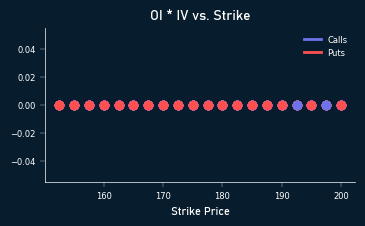

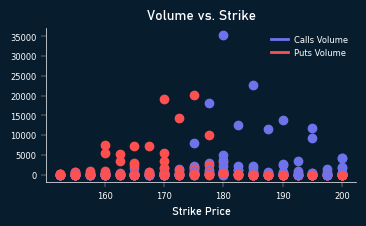

In [2]:
# Imports
# Standard library
import warnings

warnings.filterwarnings("ignore")

# Third-party libraries
import yfinance as yf # type: ignore
import pandas as pd # type: ignore
import numpy as np # type: ignore
import matplotlib.pyplot as plt # type: ignore
from datetime import datetime, timedelta

# Fetch options data for AMD
ticker = yf.Ticker('AMD')

def initialize_plot(title, xlabel, ylabel='', figsize=(4, 2)):
    fig, ax = plt.subplots(figsize=figsize)
    fig.patch.set_facecolor('#071C2D')
    ax.set_facecolor('#071C2D')
    
    # Customize the plot
    plt.title(title, fontsize=10, fontweight='bold', color='white', family='Bahnschrift')
    plt.xlabel(xlabel, color='white', family='Bahnschrift', fontsize=8)
    if ylabel:
        plt.ylabel(ylabel, fontsize=8, family='Bahnschrift', color='white')
    
    ax.tick_params(axis='x', colors='white', labelsize=6)
    ax.tick_params(axis='y', colors='white', labelsize=6)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_color('white')
    ax.spines['left'].set_color('white')
    ax.spines['bottom'].set_linewidth(0.5)
    ax.spines['left'].set_linewidth(0.5)
    ax.tick_params(axis='x', colors='white', width=0.25)
    ax.tick_params(axis='y', colors='white', width=0.25)
    
    return fig, ax

def plot_data_and_trendline(df, x_col, y_col, marker_col, color_col, legend_labels, trendline_func=None):
    fig, ax = initialize_plot(f'{y_col} vs. {x_col}', 'Strike Price')
    
    for index, row in df.iterrows():
        ax.scatter(row[x_col], row[y_col], marker=row[marker_col], color=row[color_col])
    
    if trendline_func:
        x = np.linspace(df[x_col].min(), df[x_col].max(), 100)
        ax.plot(x, trendline_func(x), color='white', linestyle='--', linewidth=1)
    
    legend_handles = [plt.Line2D([0], [0], color=color, lw=2) for color in ['#6F73EB', '#FF5050']]
    ax.legend(legend_handles, legend_labels, loc='upper right', fontsize=6, labelcolor='white', facecolor='#071C2D', framealpha=0.0, edgecolor='white')
    
    plt.show()
    plt.close()

# Get the current price of the stock
current_price = ticker.history(period="1d")["Close"][0]

# Get available expiration dates for the next six months
expirations = ticker.options
current_date = datetime.now()
six_months_later = current_date + timedelta(days=180)
available_expirations = [exp_date for exp_date in expirations if current_date <= datetime.strptime(exp_date, '%Y-%m-%d') <= six_months_later]

data = []

# Calculate bounds outside the loop
factor = current_price / 7
lower_bound = current_price - factor
upper_bound = current_price + factor

for exp_date in available_expirations:
    try:
        option_chain = ticker.option_chain(exp_date)
        if len(option_chain) != 3:
            raise ValueError(f"Expected exactly 3 items in option chain for {exp_date}, but received {len(option_chain)}.")
        calls, puts, _ = option_chain
    except Exception as e:
        print(f"Error retrieving options for {exp_date}: {e}")
        continue
    
    print(f"Fetching options data for {exp_date}")

    # Process both calls and puts in a single operation
    for option_type, marker, color in zip([calls, puts], ['o', 'o'], ['#6F73EB', '#FF5050']):
        # Use boolean indexing to filter by strike price
        filtered_options = option_type[(option_type['strike'] >= lower_bound) & (option_type['strike'] <= upper_bound)]
        
        # Create a temporary DataFrame for filtered options
        temp_data = filtered_options.assign(
            OI_IV=filtered_options['openInterest'] * filtered_options['impliedVolatility'],
            Marker=marker,
            Color=color
        )[["strike", "openInterest", "impliedVolatility", "OI_IV", "volume", "Marker", "Color"]]
        
        # Append the data to the list
        data.extend(temp_data.values.tolist())

# Convert the data to a DataFrame
df = pd.DataFrame(data, columns=['Strike', 'Open Interest', 'Implied Volatility', 'OI * IV', 'Volume', 'Marker', 'Color'])

# Fit a polynomial curve to the data
z = np.polyfit(df['Strike'], df['OI * IV'], 3)
p = np.poly1d(z)

# Plotting OI * IV
plot_data_and_trendline(df, 'Strike', 'OI * IV', 'Marker', 'Color', ['Calls', 'Puts'], trendline_func=p)

# For volume, you might not need a trendline, but if you do, fit a curve similarly and pass the function
plot_data_and_trendline(df, 'Strike', 'Volume', 'Marker', 'Color', ['Calls Volume', 'Puts Volume'], trendline_func=p)

